# Import Packages

In [1]:
import os
import json
import math
import boto3
import rasterio
import rasterio.plot
import statistics
import pyproj
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit
from scipy.interpolate import interp1d

DATA_DIRECTORY = os.getcwd()
S3_BUCKET = 'article-data'
S3_FOLDER = 'around-the-world'

# Read Data

In [2]:
filepath = os.path.join(DATA_DIRECTORY, 'ETOPO1_Ice_g_geotiff.tif')
raster = rasterio.open(filepath)
raster_height = raster.read(1)
raster.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 21601, 'height': 10801, 'count': 1, 'crs': None, 'transform': Affine(0.016666666666666666, 0.0, -180.00833333333333,
       0.0, -0.016666666666666663, 90.00833333333334), 'tiled': False, 'interleave': 'band'}

# Examine Min/Max Data

In [3]:
max_height = np.amax(raster_height)
max_height_indices = np.where(raster_height == max_height)
max_height_lat_lon = raster.xy(max_height_indices[0][0], max_height_indices[1][0])

print("Max Height: ", max_height)

print("Lat Index: ", max_height_indices[1][0])
print("Lon Index: ", max_height_indices[0][0])

print("Lat: ", max_height_lat_lon[1])
print("Lon: ", max_height_lat_lon[0])

Max Height:  8271
Lat Index:  16016
Lon Index:  3721
Lat:  27.98333333333335
Lon:  86.93333333333334


In [4]:
min_height = np.amin(raster_height)
min_height_indices = np.where(raster_height == min_height)
min_height_lat_lon = raster.xy(min_height_indices[0][0], min_height_indices[1][0])

print("Min Height: ", min_height)

print("Lat Index: ", min_height_indices[1][0])
print("Lon Index: ", min_height_indices[0][0])

print("Lat: ", min_height_lat_lon[1])
print("Lon: ", min_height_lat_lon[0])

Min Height:  -10898
Lat Index:  19331
Lon Index:  4719
Lat:  11.350000000000023
Lon:  142.18333333333334


# Plot Data

In [5]:
def get_distances(index, raster, raster_height, previous_distance=0, previous_height=0, reverse=False):
    base = 1.8532513372265385 #km or 0.166666666666 degrees
    distances = []
    is_first = True
    indices = list(reversed(range(raster.height))) if reverse else range(raster.height)
    for i in indices:
        if is_first:
            adjustment = 0
            if reverse:
                prev_height = previous_height
                current_height = raster_height[i, index]
                adjustment = math.sqrt(base**2 + (prev_height-current_height)**2)
            distances.append(previous_distance + adjustment)
            is_first = False
        else:
            prev_distance = distances[indices[0] - i - 1] if reverse else distances[i - 1]
            prev_height = raster_height[i - 1, index]
            current_height = raster_height[i, index]
            
            distance = math.sqrt(base**2 + (prev_height-current_height)**2)
            distances.append(distance + prev_distance)
    return distances

def get_antipode_longitude(longitude):
    antipode_longitude = 180 - abs(longitude)
    if longitude > 0:
        antipode_longitude = -1 * antipode_longitude
    return antipode_longitude


def get_elevation_path(latitude, longitude, raster, raster_height, s3_client=None, should_plot=False, output_file=False):
    antipode_longitude = get_antipode_longitude(longitude)
    negative_longitude = antipode_longitude if longitude >= 0 else longitude
    positive_longitude = longitude if longitude >= 0 else antipode_longitude
    
    # Get the first part of the path (negative longitude)
    raster_index = raster.index(negative_longitude, latitude)
    lon_index = raster_index[1]
    distances = get_distances(lon_index, raster, raster_height)
    heights = [raster_height[i, lon_index] for i in range(raster.height)]
    
    # Get the other half of the path (positive longitude)
    inv_raster_index = raster.index(positive_longitude, -latitude)
    inv_lon_index = inv_raster_index[1]
    inv_distances = get_distances(inv_lon_index, raster, raster_height, previous_distance=distances[-1], previous_height=heights[-1], reverse=True)
    inv_heights = [raster_height[i, inv_lon_index] for i in range(raster.height)][::-1]
    
    # Combine the two paths
    combined_distances = distances + inv_distances
    combined_heights = heights + inv_heights
    
    
    if output_file:
        output_json = {
            "distance": [round(i) for i in combined_distances],
            "elevation": [int(i) for i in combined_heights],
        }
        output_filename = "{0}.json".format(lon_index)
        if s3_client is not None:
            print("Outputting file to s3 for index: {0}".format(lon_index))
            client.put_object(
                Body=bytes(json.dumps(output_json).encode('UTF-8')),
                Bucket=S3_BUCKET,
                Key='{0}/{1}'.format(S3_FOLDER, output_filename)
            )
        else:
            with open(output_filename, "w") as f:
                json.dump(output_json, f)

            
    if should_plot:
        lat_index = raster_index[0]
        inv_lat_index = inv_raster_index[0]
        reverse_lat_index = len(combined_heights) - lat_index - 1
        point_index = reverse_lat_index if longitude >= 0 else lat_index
        
        axes = plt.gca()
        # Mariana Trench is 11K+ meters deep!
        axes.set_ylim([-11000,11000])
        plt.plot(combined_heights)
        plt.plot(
#             [combined_distances[point_index]],
            point_index,
            [combined_heights[point_index]],
            marker='o',
            markersize=10,
            color="red"
        )
        
        latitudes = [raster.xy(i, lon_index)[1] for i in range(raster.height)]
        inv_latitudes = [raster.xy(i, inv_lon_index)[1] for i in range(raster.height)][::-1]
        combined_latitudes = latitudes + inv_latitudes
        
        return combined_distances, combined_latitudes, combined_heights, point_index
    
    
    return combined_distances, None, combined_heights, None

In [ ]:
# Mt. Everest
lat = max_height_lat_lon[1]
lon = max_height_lat_lon[0]
d, l, h, i = get_elevation_path(lat, lon, raster, raster_height, should_plot=True)

In [ ]:
# Mariana Trench
lat = min_height_lat_lon[1]
lon = min_height_lat_lon[0]
d, l, h, i = get_elevation_path(lat, lon, raster, raster_height, should_plot=True)

In [ ]:
# Mayagüez
lat = 18.204498
lon = -67.126673
d, l, h, i = get_elevation_path(lat, lon, raster, raster_height, should_plot=True)

In [ ]:
# Mayagüez's antipode
lat = 18.204498
lon = 112.873327
d, l, h, i = get_elevation_path(lat, lon, raster, raster_height, should_plot=True)

# Interpolation Example

In [ ]:
num_new_points = 10000
inew = round(i * num_new_points / (len(h)-1))
xnew = np.linspace(0, len(h)-1, num=num_new_points)
f = interp1d(list(range(len(h))), h)
ynew = f(xnew)
plt.plot(ynew)
plt.plot(
    inew,
    [ynew[inew]],
    marker='o',
    markersize=10,
    color="red"
)
plt.show()

# Output Files

In [ ]:
session = boto3.Session(
    aws_access_key_id=os.environ['AWS_ACCESS_KEY'],
    aws_secret_access_key=os.environ['AWS_SECRET_KEY'],
)
client = session.client('s3')

In [ ]:
index = 0
while index <= 10801:
    longitude_increment = 0.016666666666666666
    longitude = -180 + longitude_increment * index
    d, l, h, i = get_elevation_path(0, longitude, raster, raster_height, s3_client=client, output_file=True)
    index += 1

# Ridgeline Latitudes

In [6]:
def interpolate_list(lst, n = 500):
    xnew = np.linspace(0, len(lst)-1, num=n)
    f = interp1d(list(range(len(lst))), lst, kind='previous')
    ynew = f(xnew)
    return ynew

In [7]:
index = 3721 # 3721 4719
test_array = interpolate_list(raster_height[index], n=100)
print("    ", "Actual", " ", "Smooth")
print("Max ", "", max(raster_height[index]), "  ", max(test_array))
print("Min ", min(raster_height[index]), " ", min(test_array))

     Actual   Smooth
Max   8271    5753.0
Min  -8642   -7137.0


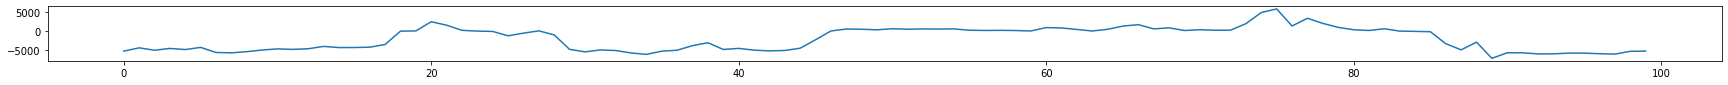

In [8]:
plt.figure(figsize=(30,1))
plt.plot(test_array)
plt.show()

In [30]:
def interpolate_latitude_chunks(raster_height, num_slices=180, num_points=500):
    num_rows = len(raster_height)
    slice_length = math.floor(num_rows / num_slices)
    all_salient_heights = []
    
    interpolated_heights = {
        "pos": {},
        "neg": {}
    }
    
    for i in range(num_slices):
        interpolated_heights["pos"][str(i)] = {}
        interpolated_heights["neg"][str(i)] = {}

        
        start_index = i * slice_length
        end_index = (i + 1) * slice_length
        current_height = raster_height[start_index:end_index]
        interpolated_height = np.array([interpolate_list(row, n=num_points) for row in current_height])
        
        salient_height = []
        
        is_same_sign = True
        segment_heights = []
        start_idx = 0
        end_idx = 0
        for j in range(num_points):
            col_heights = interpolated_height[:,j]
            col_median = statistics.median(col_heights)
            col_value = max(col_heights) if col_median > 0 else min(col_heights)
            
            # Determine previous value
            if j == 0:
                prev_value = col_value
            else:
                prev_value = salient_height[j - 1]
            
            # Determine whether the elevation sign has switched
            # (+)(+) = (+), (-)(-) = (+), (-)(+) = (-), (+)(-) = (-)
            is_same_sign = (col_value * prev_value) > 0 or (prev_value >= 0 and col_value == 0) or (prev_value == 0 and col_value >= 0)
                        
            if ((is_same_sign and j == (num_points - 1)) or not is_same_sign):
                # Add a sea level elevation marker at a half-index
                if j == (num_points - 1):
                    segment_heights.append(col_value)
                    end_idx = j
                    start_idx = start_idx
                else:
                    segment_heights.append(0)
                    end_idx = j + 0.5
                    start_idx = start_idx + 0.5 if start_idx is not 0 else start_idx
                
                if prev_value >= 0:
                    interpolated_heights["pos"][str(i)]["{0}:{1}".format(start_idx, end_idx)] = segment_heights
                else:
                    interpolated_heights["neg"][str(i)]["{0}:{1}".format(start_idx, end_idx)] = segment_heights
                # Reset segment
                segment_heights = [0, col_value]
                start_idx = j
            elif is_same_sign:
                segment_heights.append(col_value)
            
            salient_height.append(col_value)
            
        all_salient_heights.append(salient_height)
    
    all_salient_heights = np.array(all_salient_heights)
    output_filepath = os.path.join(DATA_DIRECTORY, "ridgeline_matrix_{0}.csv".format(num_points))
    np.savetxt(output_filepath, all_salient_heights, delimiter=",", fmt='%i')
    
    output_json_filepath = os.path.join(DATA_DIRECTORY, 'ridgeline_{0}.json'.format(num_points))
    with open(output_json_filepath, 'w') as fp:
        json.dump(interpolated_heights, fp)
    
    return all_salient_heights, interpolated_heights

In [10]:
ridgeline_matrix, ridgeline_dict = interpolate_latitude_chunks(raster_height, num_slices=60, num_points=200)

In [ ]:
ridge_max = np.amax(ridgeline_matrix)
ridge_max_index = np.where(ridgeline_matrix == ridge_max)

ridge_min = np.amin(ridgeline_matrix)
ridge_min_index = np.where(ridgeline_matrix == ridge_min)

print(ridge_max, ridge_min)

In [ ]:
# Inefficiently outputting different line densities
ridgeline_matrix, ridgeline_dict = interpolate_latitude_chunks(raster_height, num_slices=180, num_points=100)
ridgeline_matrix, ridgeline_dict = interpolate_latitude_chunks(raster_height, num_slices=180, num_points=250)
ridgeline_matrix, ridgeline_dict = interpolate_latitude_chunks(raster_height, num_slices=500, num_points=500)
ridgeline_matrix, ridgeline_dict = interpolate_latitude_chunks(raster_height, num_slices=180, num_points=1000)

In [ ]:
ridgeline_matrix, ridgeline_dict = interpolate_latitude_chunks(raster_height, num_slices=360, num_points=5000)

In [ ]:
ridgeline_matrix, ridgeline_dict = interpolate_latitude_chunks(raster_height, num_slices=360, num_points=500)

In [ ]:
ridgeline_matrix, ridgeline_dict = interpolate_latitude_chunks(raster_height, num_slices=60, num_points=1000)

In [ ]:
ridgeline_matrix, ridgeline_dict = interpolate_latitude_chunks(raster_height, num_slices=350, num_points=500)

In [31]:
ridgeline_matrix, ridgeline_dict = interpolate_latitude_chunks(raster_height, num_slices=300, num_points=500)

In [32]:
ridgeline_matrix, ridgeline_dict = interpolate_latitude_chunks(raster_height, num_slices=180, num_points=250)